In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
#importing the dataset
train=pd.read_csv("./train.csv")

## Looking at the data

The training data contains a row per comment, with an id, the text of the comment, and 6 different labels that we'll try to predict.

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Here's a couple of examples of comments, one toxic, and one with no labels.

In [5]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [6]:
train['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

The length of the comments varies a lot.

In [7]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048919, 5000)

We'll create a list of all the labels to predict, and we'll also create a 'none' label so we can see how many comments have no labels. We can then summarize the dataset.

In [8]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
len(train)#,len(test)

159571

There are a few empty comments that we need to get rid of, otherwise sklearn will complain.

## EDA of the dataset

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting the plot style to ggplot
plt.style.use('ggplot')

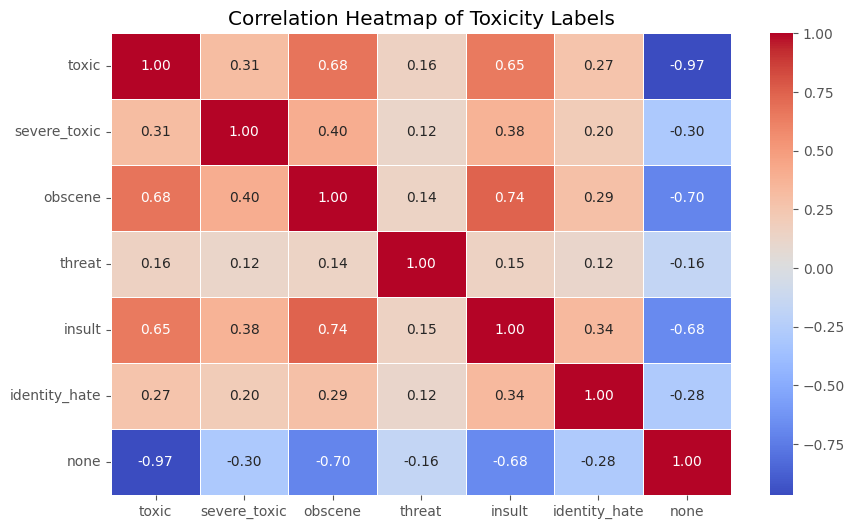

In [11]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','none']
plt.figure(figsize=(10, 6))
sns.heatmap(train[labels].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Toxicity Labels")
plt.show()


C:\Users\Ishant Bansal\AppData\Local\Temp\ipykernel_6812\921649873.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='Set2')


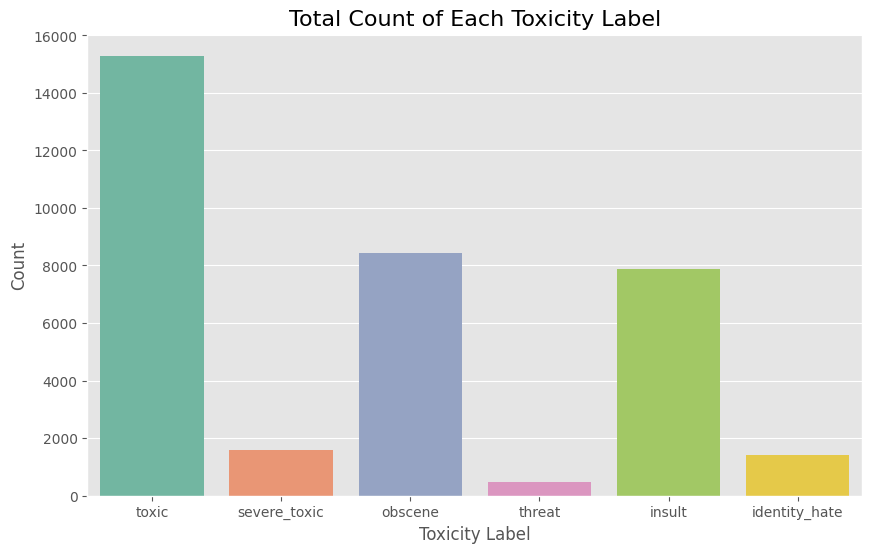

In [12]:
label_counts = train[label_cols].sum()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='Set2')

# Adding titles and labels
plt.title('Total Count of Each Toxicity Label', fontsize=16)
plt.xlabel('Toxicity Label', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.show()

C:\Users\Ishant Bansal\AppData\Local\Temp\ipykernel_6812\508924397.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['comment_length'], bins=50, kde=True, color='purple')


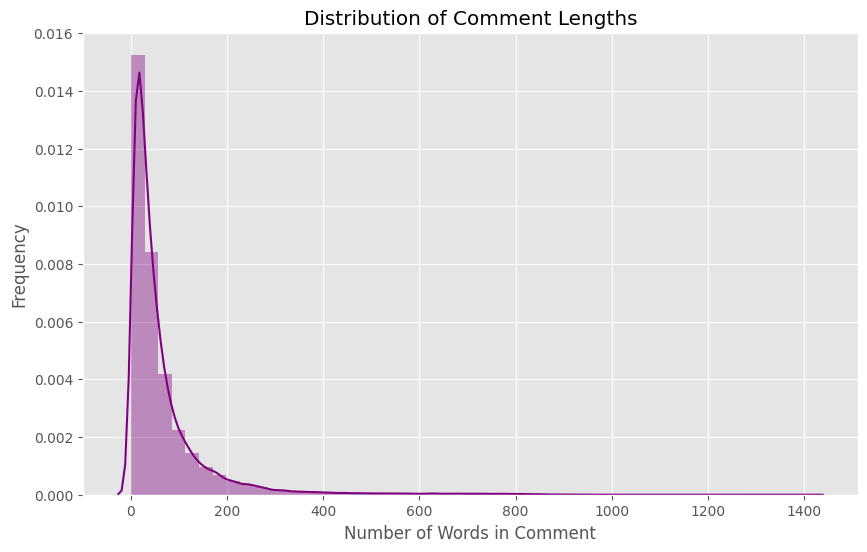

In [13]:
df = train.copy()
df['comment_length'] = df['comment_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.distplot(df['comment_length'], bins=50, kde=True, color='purple')
plt.title("Distribution of Comment Lengths")
plt.xlabel("Number of Words in Comment")
plt.ylabel("Frequency")

plt.show()

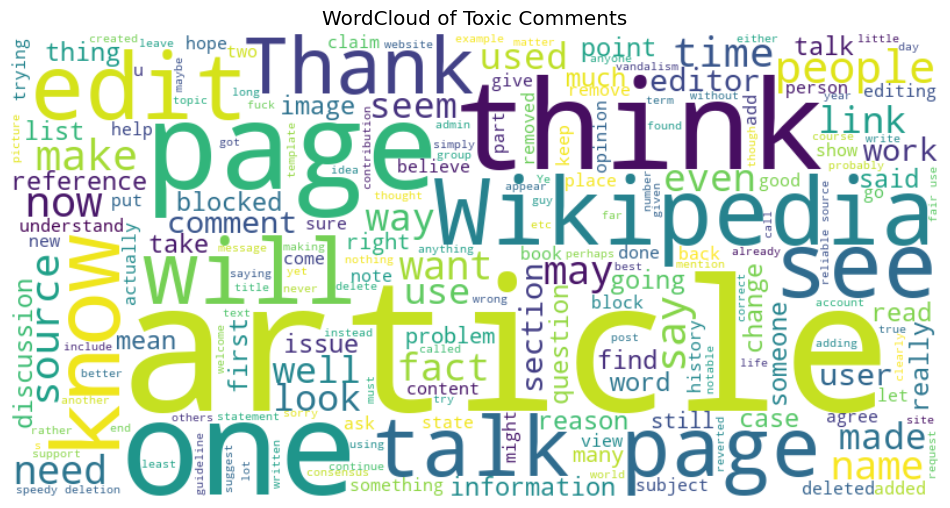

In [14]:
from wordcloud import WordCloud

toxic_comments = ' '.join(df['comment_text'])

plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(toxic_comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Toxic Comments")
plt.show()

## Building the model

We'll start by creating a *bag of words* representation, as a *term document matrix*. We'll use ngrams, as suggested in the NBSVM paper.

### TF-IDF + Logistic Regression

In [15]:
train['comment_text'].fillna("unknown", inplace=True)

C:\Users\Ishant Bansal\AppData\Local\Temp\ipykernel_6812\3123226752.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['comment_text'].fillna("unknown", inplace=True)


In [16]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import re, string

def tokenize(text):
    text = re.sub(f"[{string.punctuation}]", "", text.lower())
    return text.split()

train_data, test_data = train_test_split(train, test_size=0.2, random_state=42)



In [17]:
    
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 2), min_df=3, max_df=0.9)
train_tfidf = tfidf_vectorizer.fit_transform(train_data['comment_text'])
test_tfidf = tfidf_vectorizer.transform(test_data['comment_text'])


c:\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [18]:
# Logistic Regression classifier for each class
lr_model = LogisticRegression(max_iter=1000)
metrics_lr = {}

# Use train_data to fit the model
for label in label_cols:
    lr_model.fit(train_tfidf, train_data[label])  # Corrected to use train_data
    preds = lr_model.predict(test_tfidf)
    metrics_lr[label] = {
        'accuracy': accuracy_score(test_data[label], preds),
        'f1': f1_score(test_data[label], preds),
        'precision': precision_score(test_data[label], preds),
        'recall': recall_score(test_data[label], preds)
    }

print("Approach 1 (TF-IDF + Logistic Regression) Results:", metrics_lr)

Approach 1 (TF-IDF + Logistic Regression) Results: {'toxic': {'accuracy': 0.9535014883283722, 'f1': 0.6956521739130435, 'precision': 0.9318681318681319, 'recall': 0.5549738219895288}, 'severe_toxic': {'accuracy': 0.9904433651887827, 'f1': 0.2823529411764706, 'precision': 0.5769230769230769, 'recall': 0.18691588785046728}, 'obscene': {'accuracy': 0.9734294219019269, 'f1': 0.6886930983847284, 'precision': 0.929633300297324, 'recall': 0.5469387755102041}, 'threat': {'accuracy': 0.9978693404355319, 'f1': 0.20930232558139536, 'precision': 0.75, 'recall': 0.12162162162162163}, 'insult': {'accuracy': 0.9692934356885478, 'f1': 0.608, 'precision': 0.8577878103837472, 'recall': 0.4708798017348203}, 'identity_hate': {'accuracy': 0.9916026946576845, 'f1': 0.21176470588235294, 'precision': 0.782608695652174, 'recall': 0.12244897959183673}}


In [33]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import re, string

# Define a simple tokenizer function
def tokenize(text):
    text = re.sub(f"[{string.punctuation}]", "", text.lower())
    return text.split()

# Load the training data
train_data = pd.read_csv('train.csv')  # Replace with your actual training dataset

# Load the new test data
test_data = pd.read_csv('test.csv')

# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 2), min_df=3, max_df=0.9)
train_tfidf = tfidf_vectorizer.fit_transform(train_data['comment_text'])
test_tfidf = tfidf_vectorizer.transform(test_data['comment_text'])

# Define label columns
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Initialize Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Predict labels for each class and add to the submission
for label in label_cols:
    # Train the model for this label
    lr_model.fit(train_tfidf, train_data[label])
    
    # Predict on test data
    test_data[label] = lr_model.predict(test_tfidf)

# Prepare the final submission file
submission = test_data[['id'] + label_cols]
submission.to_csv('submission.csv', index=False)

print("New submission file 'submission.csv' created successfully.")


c:\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


New submission file 'submission.csv' created successfully.


In [19]:
data = []

# Collect data for each label from the metrics
for label in label_cols:
    data.append({
        'Class': label,
        'Accuracy': metrics_lr[label]['accuracy'],
        'F1 Score': metrics_lr[label]['f1'],
        'Precision': metrics_lr[label]['precision'],
        'Recall': metrics_lr[label]['recall'],
    })

# Create the DataFrame
metrics_df_lr = pd.DataFrame(data)

# Display the DataFrame
metrics_df_lr

,Class,Accuracy,F1 Score,Precision,Recall
0,toxic,0.953501,0.695652,0.931868,0.554974
1,severe_toxic,0.990443,0.282353,0.576923,0.186916
2,obscene,0.973429,0.688693,0.929633,0.546939
3,threat,0.997869,0.209302,0.750000,0.121622
4,insult,0.969293,0.608000,0.857788,0.470880
5,identity_hate,0.991603,0.211765,0.782609,0.122449


### Count Vectorizer + Naive Bayes

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Count Vectorizer
count_vectorizer = CountVectorizer(tokenizer=tokenize, ngram_range=(1, 2), min_df=3)
train_count = count_vectorizer.fit_transform(train_data['comment_text'])
test_count = count_vectorizer.transform(test_data['comment_text'])

# Naive Bayes classifier for each class
nb_model = MultinomialNB()
metrics_nb = {}

for label in label_cols:
    nb_model.fit(train_count, train_data[label])
    preds = nb_model.predict(test_count)
    metrics_nb[label] = {
        'accuracy': accuracy_score(test_data[label], preds),
        'f1': f1_score(test_data[label], preds),
        'precision': precision_score(test_data[label], preds),
        'recall': recall_score(test_data[label], preds)
    }

print("Approach 2 (Count Vectorizer + Naive Bayes) Results:", metrics_nb)


c:\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Approach 2 (Count Vectorizer + Naive Bayes) Results: {'toxic': {'accuracy': 0.9362995456681811, 'f1': 0.6895709268590624, 'precision': 0.6464357286000573, 'recall': 0.7388743455497382}, 'severe_toxic': {'accuracy': 0.9853987153376156, 'f1': 0.44258373205741625, 'precision': 0.3592233009708738, 'recall': 0.5763239875389408}, 'obscene': {'accuracy': 0.9610527964906783, 'f1': 0.6657703683785964, 'precision': 0.6177644710578842, 'recall': 0.721865889212828}, 'threat': {'accuracy': 0.996960676797744, 'f1': 0.18487394957983194, 'precision': 0.24444444444444444, 'recall': 0.14864864864864866}, 'insult': {'accuracy': 0.9584208052639824, 'f1': 0.6237595690388432, 'precision': 0.575013068478829, 'recall': 0.6815365551425031}, 'identity_hate': {'accuracy': 0.9871533761554128, 'f1': 0.23220973782771537, 'precision': 0.25833333333333336, 'recall': 0.2108843537414966}}


In [21]:
data = []

# Collect data for each label from the metrics
for label in label_cols:
    data.append({
        'Class': label,
        'Accuracy': metrics_nb[label]['accuracy'],
        'F1 Score': metrics_nb[label]['f1'],
        'Precision': metrics_nb[label]['precision'],
        'Recall': metrics_nb[label]['recall'],
    })

# Create the DataFrame
metrics_df_nb = pd.DataFrame(data)

# Display the DataFrame
metrics_df_nb

,Class,Accuracy,F1 Score,Precision,Recall
0,toxic,0.936300,0.689571,0.646436,0.738874
1,severe_toxic,0.985399,0.442584,0.359223,0.576324
2,obscene,0.961053,0.665770,0.617764,0.721866
3,threat,0.996961,0.184874,0.244444,0.148649
4,insult,0.958421,0.623760,0.575013,0.681537
5,identity_hate,0.987153,0.232210,0.258333,0.210884


### Word Embeddings (GloVe) + LSTM 

In [25]:
from tensorflow import keras

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
import numpy as np

# Tokenization using Keras Tokenizer
tokenizer = Tokenizer(num_words=20000)  # Limit vocabulary size
tokenizer.fit_on_texts(train_data['comment_text'])
train_sequences = tokenizer.texts_to_sequences(train_data['comment_text'])
test_sequences = tokenizer.texts_to_sequences(test_data['comment_text'])

# Padding sequences to ensure same length
max_seq_len = 100
train_padded = pad_sequences(train_sequences, maxlen=max_seq_len)
test_padded = pad_sequences(test_sequences, maxlen=max_seq_len)

# Load GloVe embeddings (assuming GloVe embeddings are pre-downloaded)
embedding_index = {}

with open("/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Prepare embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# LSTM Model
def build_lstm_model():
    model = Sequential([
        Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(6, activation='sigmoid')  # 6 output neurons for multi-label classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt'

In [19]:

# Build and train the LSTM model
lstm_model = build_lstm_model()
lstm_model.fit(train_padded, train_data[label_cols].values, epochs=3, batch_size=128, validation_split=0.1)

# Evaluate on test data
lstm_preds = lstm_model.predict(test_padded)
metrics_lstm = {}

for i, label in enumerate(label_cols):
    lstm_bin_preds = (lstm_preds[:, i] > 0.5).astype(int)
    metrics_lstm[label] = {
        'accuracy': accuracy_score(test_data[label], lstm_bin_preds),
        'f1': f1_score(test_data[label], lstm_bin_preds),
        'precision': precision_score(test_data[label], lstm_bin_preds),
        'recall': recall_score(test_data[label], lstm_bin_preds)
    }

print("Approach 3 (Word Embeddings + LSTM) Results:", metrics_lstm)

Train on 114890 samples, validate on 12766 samples
Epoch 1/3
114890/114890 [==============================] - 117s 1ms/step - loss: 0.0955 - acc: 0.9701 - val_loss: 0.0632 - val_acc: 0.9772
Epoch 2/3
114890/114890 [==============================] - 116s 1ms/step - loss: 0.0627 - acc: 0.9785 - val_loss: 0.0585 - val_acc: 0.9789
Epoch 3/3
114890/114890 [==============================] - 117s 1ms/step - loss: 0.0582 - acc: 0.9798 - val_loss: 0.0572 - val_acc: 0.9790
Approach 3 (Word Embeddings + LSTM) Results: {'toxic': {'accuracy': 0.95791947360175467, 'f1': 0.74472533738832924, 'precision': 0.8884353741496599, 'recall': 0.64103403141361259}, 'severe_toxic': {'accuracy': 0.99003603321322264, 'f1': 0.28054298642533931, 'precision': 0.51239669421487599, 'recall': 0.19314641744548286}, 'obscene': {'accuracy': 0.9772834090553032, 'f1': 0.76422764227642281, 'precision': 0.86397058823529416, 'recall': 0.685131195335277}, 'threat': {'accuracy': 0.99768134106219641, 'f1': 0.0, 'precision': 0.0, 

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
data = []

# Collect data for each label from the metrics
for label in label_cols:
    data.append({
        'Class': label,
        'Accuracy': metrics_lstm[label]['accuracy'],
        'F1 Score': metrics_lstm[label]['f1'],
        'Precision': metrics_lstm[label]['precision'],
        'Recall': metrics_lstm[label]['recall'],
    })

# Create the DataFrame
metrics_df_lstm = pd.DataFrame(data)

# Display the DataFrame
metrics_df_lstm

,Accuracy,Class,F1 Score,Precision,Recall
0,0.957919,toxic,0.744725,0.888435,0.641034
1,0.990036,severe_toxic,0.280543,0.512397,0.193146
2,0.977283,obscene,0.764228,0.863971,0.685131
3,0.997681,threat,0.000000,0.000000,0.000000
4,0.969387,insult,0.653669,0.763877,0.571252
5,0.990851,identity_hate,0.026667,0.666667,0.013605


## Comparing Results

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming metrics_lr, metrics_nb, and metrics_lstm have been defined earlier
# Extracting average scores from each approach for all metrics
approach_metrics = {
    'TF-IDF + Logistic Regression': metrics_lr,
    'Count Vectorizer + Naive Bayes': metrics_nb,
    'Word Embeddings + LSTM': metrics_lstm
}

# Averaging the metrics across all six labels
def average_metrics(metrics_dict):
    avg_metrics = {'accuracy': [], 'f1': [], 'precision': [], 'recall': []}
    for metric in avg_metrics:
        avg_metrics[metric] = np.mean([metrics_dict[label][metric] for label in label_cols])
    return avg_metrics

# Calculate average metrics for each approach
avg_metrics_lr = average_metrics(metrics_lr)
avg_metrics_nb = average_metrics(metrics_nb)
avg_metrics_lstm = average_metrics(metrics_lstm)

# Data for bar plot
labels = ['accuracy', 'f1', 'precision', 'recall']
lr_scores = [avg_metrics_lr[m] for m in labels]
nb_scores = [avg_metrics_nb[m] for m in labels]
lstm_scores = [avg_metrics_lstm[m] for m in labels]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, lr_scores, width, label='TF-IDF + Logistic Regression')
ax.bar(x, nb_scores, width, label='Count Vectorizer + Naive Bayes')
ax.bar(x + width, lstm_scores, width, label='Word Embeddings + LSTM')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Classification Approaches')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


NameError: name 'metrics_lstm' is not defined

In [39]:
import pandas as pd

# Create a list to hold the data for the DataFrame
data = []

# Collect data for each class from all models
for class_label in label_cols:
    data.append({
        'Class': class_label,
        'TF-IDF + Logistic Regression Accuracy': metrics_lr[class_label]['accuracy'],
        'TF-IDF + Logistic Regression F1 Score': metrics_lr[class_label]['f1'],
        'TF-IDF + Logistic Regression Precision': metrics_lr[class_label]['precision'],
        'TF-IDF + Logistic Regression Recall': metrics_lr[class_label]['recall'],
        'Count Vectorizer + Naive Bayes Accuracy': metrics_nb[class_label]['accuracy'],
        'Count Vectorizer + Naive Bayes F1 Score': metrics_nb[class_label]['f1'],
        'Count Vectorizer + Naive Bayes Precision': metrics_nb[class_label]['precision'],
        'Count Vectorizer + Naive Bayes Recall': metrics_nb[class_label]['recall'],
        'Word Embeddings + LSTM Accuracy': metrics_lstm[class_label]['accuracy'],
        'Word Embeddings + LSTM F1 Score': metrics_lstm[class_label]['f1'],
        'Word Embeddings + LSTM Precision': metrics_lstm[class_label]['precision'],
        'Word Embeddings + LSTM Recall': metrics_lstm[class_label]['recall'],
    })

# Create the DataFrame
metrics_df = pd.DataFrame(data)

metrics_df_rotated = metrics_df.T

# Display the rotated DataFrame
metrics_df_rotated

,0,1,2,3,4,5
Class,toxic,severe_toxic,obscene,threat,insult,identity_hate
Count Vectorizer + Naive Bayes Accuracy,0.9363,0.985399,0.961053,0.996961,0.958421,0.987153
Count Vectorizer + Naive Bayes F1 Score,0.689571,0.442584,0.66577,0.184874,0.62376,0.23221
Count Vectorizer + Naive Bayes Precision,0.646436,0.359223,0.617764,0.244444,0.575013,0.258333
Count Vectorizer + Naive Bayes Recall,0.738874,0.576324,0.721866,0.148649,0.681537,0.210884
TF-IDF + Logistic Regression Accuracy,0.953407,0.990349,0.973429,0.997807,0.969011,0.991571
TF-IDF + Logistic Regression F1 Score,0.696345,0.276995,0.688006,0.125,0.602652,0.192192
TF-IDF + Logistic Regression Precision,0.926127,0.561905,0.932203,0.833333,0.857143,0.820513
TF-IDF + Logistic Regression Recall,0.557919,0.183801,0.54519,0.0675676,0.464684,0.108844
Word Embeddings + LSTM Accuracy,0.957919,0.990036,0.977283,0.997681,0.969387,0.990851
